In [1]:
!pip install pandas numpy matplotlib seaborn nltk textblob wordcloud

In [91]:
import pandas as pd
# Loading data 
df = pd.read_csv(r"C:\Users\sentiment_analysis_amazon.csv", encoding='utf-8')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [92]:
# Remove neutral reviews (Score == 3)
df = df[df['Score'] != 3]
# Create sentiment column
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)
# Check value counts
df['Sentiment'].value_counts()

Sentiment
1    201
0     29
Name: count, dtype: int64

In [79]:
# Remove missing values if any
df = df[['Text', 'Sentiment']]
df = df.dropna()  
df.head()

,Text,Sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [80]:
import re
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text) 
    # remove punctuation & numbers
    return text
df['Cleaned_Text'] = df['Text'].apply(clean_text)
df[['Cleaned_Text', 'Sentiment']].head()

,Cleaned_Text,Sentiment
0,i have bought several of the vitality canned d...,1
1,product arrived labeled as jumbo salted peanut...,0
2,this is a confection that has been around a fe...,1
3,if you are looking for the secret ingredient i...,0
4,great taffy at a great price there was a wide...,1


In [81]:
from sklearn.utils import resample
positive = df[df['Sentiment'] == 1]
negative = df[df['Sentiment'] == 0]
negative_upsampled = resample(
    negative,
    replace=True,               # sample with replacement
    n_samples=len(positive),    # match number of positive samples
    random_state=42
)
#Combine and shuffle
balanced_df = pd.concat([positive, negative_upsampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
#Check final class distribution
print(balanced_df['Sentiment'].value_counts())

Sentiment
0    201
1    201
Name: count, dtype: int64


In [82]:
# Training a model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
# Features (text)
X = df['Cleaned_Text']
# Labels (positive/negative)
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# Initialize TF-IDF Vectorizer
# limit to top 5000 words
vectorizer = TfidfVectorizer(max_features = 5000, ngram_range=(1,2))  
# Fit on training data and transform both train and test
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
# Initialize and train the model
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

In [35]:
import numpy as np
print("Predicted labels:", np.unique(y_pred, return_counts=True))
print("Actual labels:", np.unique(y_test, return_counts=True))

Predicted labels: (array([1]), array([46]))
Actual labels: (array([0, 1]), array([ 3, 43]))


In [83]:
from sklearn.metrics import classification_report
# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))

Accuracy: 0.9347826086956522
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         3
           1       0.93      1.00      0.97        43

    accuracy                           0.93        46
   macro avg       0.97      0.50      0.48        46
weighted avg       0.94      0.93      0.90        46



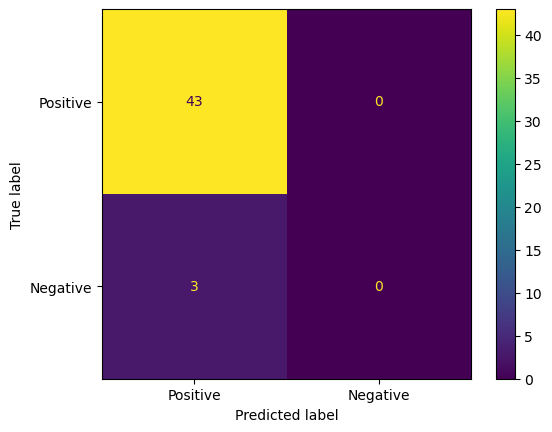

In [84]:
#Using Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Compute confusion matrix with integer labels
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
# Display the confusion matrix with human-readable labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Positive", "Negative"])
disp.plot()

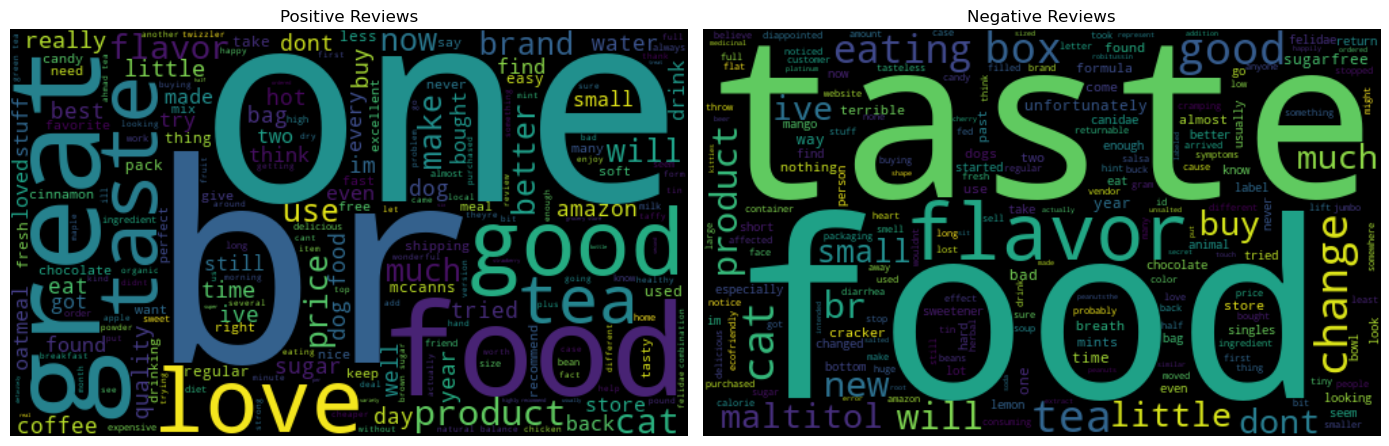

In [85]:
# Using Word Cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Separate text by sentiment
positive_text = " ".join(df[df['Sentiment'] == 1]['Cleaned_Text'])
negative_text = " ".join(df[df['Sentiment'] == 0]['Cleaned_Text'])
# Generate word clouds
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=500, height=300).generate(positive_text), interpolation='bilinear')
plt.axis('off')
plt.title("Positive Reviews")
plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=500, height=300).generate(negative_text), interpolation='bilinear')
plt.axis('off')
plt.title("Negative Reviews")
plt.tight_layout()
plt.show()

In [86]:
import joblib
# Save model and vectorizer
model = joblib.load(r"C:\Users\Chabri Ganesh\sentiment-app\sentiment_model.pkl")  # load directly, no need to open file
vectorizer = joblib.load(r"C:\Users\Chabri Ganesh\sentiment-app\tfidf_vectorizer.pkl")
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [93]:
# Retraining the Model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib
# Clean the text column (remove nulls)
df = df[['Text', 'Score']].dropna()
# Apply correct sentiment label
df['Sentiment'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)
# Features and Labels
X = balanced_df['Text']
y = balanced_df['Sentiment']
# Vectorization
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)
# Train model
model = LogisticRegression()
model.fit(X_train, y_train)
# Save model and vectorizer
joblib.dump(model, 'sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [94]:
import joblib
model = joblib.load(r"C:\Users\Chabri Ganesh\sentiment-app\sentiment_model.pkl")
vectorizer = joblib.load(r"C:\Users\Chabri Ganesh\sentiment-app\tfidf_vectorizer.pkl")
print(type(model))
print(type(vectorizer))

<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [95]:
import joblib
model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
with open('model_info.txt', 'w', encoding='utf-8') as f:
    f.write(f"Model type: {type(model).__name__}\n")
    f.write(f"Vectorizer type: {type(vectorizer).__name__}\n")
    f.write(f"Vocabulary size: {len(vectorizer.vocabulary_)}\n")

In [96]:
# Example text to analyze
text = ["I really loved this product!"]
# Convert text to numeric features
X = vectorizer.transform(text)
# Get prediction
prediction = model.predict(X)
print("Predicted sentiment:", prediction)
# If you want probabilities
prob = model.predict_proba(X)
print("Prediction probabilities:", prob)

Predicted sentiment: [1]
Prediction probabilities: [[0.16171626 0.83828374]]
